In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, GRU, Flatten
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

In [3]:
number_of_samples = 50000 #determine how many samples from the attack and normal dataset should be read and used.

In [4]:
data_attack = pd.read_csv('./dataset/dataset_attack.csv', nrows = number_of_samples)

In [5]:
data_normal = pd.read_csv('./dataset/dataset_normal.csv', nrows = number_of_samples)

In [6]:
data_normal.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']
data_attack.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']

In [7]:
#removing unnecessary columns
data_normal=data_normal.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1) 
data_attack=data_attack.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)

In [8]:
#required features
features=[ 'frame.len', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta']

In [9]:
#merging data from both attack and normal dataset
X_normal= data_normal[features].values
X_attack= data_attack[features].values
Y_normal= data_normal['class']
Y_attack= data_attack['class']
X=np.concatenate((X_normal,X_attack))
Y=np.concatenate((Y_normal,Y_attack))

In [10]:
#normalizing the training data
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [11]:
#converting attack values as 0 and normal values as 1
for i in range(0,len(Y)):
  if Y[i] =="attack":
    Y[i]=0
  else:
    Y[i]=1
    

In [32]:
#transforming the input data into time based windows to train our model
def transform(X):
    features = len(X[0])
    samples = X.shape[0]
    train_len = 25
    input_len = samples - train_len
    I = np.zeros((samples - train_len, train_len, features))

    for i in range(input_len):
        temp = np.zeros((train_len, features))
        for j in range(i, i + train_len - 1):
            temp[j-i] = X[j]
        I[i] = temp
    return I

In [33]:
I = transform(X)

In [34]:
X.shape

(100000, 25)

In [35]:
I.shape

(99975, 25, 25)

In [15]:
# Splitting the data into test and test datas
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[25:100000], test_size = 0.2)

In [16]:
X_train.shape

(79980, 25, 25)

In [17]:
X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

In [18]:
model_name = "GRU"

In [19]:
#defining the bi-directional-model
def bidirectionalRNN():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [20]:
#defining the GRU model
def gruModel():
    model = Sequential()
    model.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [21]:
if model_name == "GRU":
    model = gruModel()
elif model_name == "BRNN":
    model = bidirectionalRNN() 

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 25, 64)            17472     
                                                                 
 gru_1 (GRU)                 (None, 25, 32)            9408      
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 1)                 801       
                                                                 
Total params: 27681 (108.13 KB)
Trainable params: 27681 (108.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
history = model.fit(X_train, Y_train, epochs = 10,validation_split=0.2, verbose = 1)

Epoch 1/10
2000/2000 [==============================] - 26s 12ms/step - loss: 0.1240 - accuracy: 0.9584 - val_loss: 0.0842 - val_accuracy: 0.9731
Epoch 2/10
2000/2000 [==============================] - 21s 11ms/step - loss: 0.0803 - accuracy: 0.9729 - val_loss: 0.0716 - val_accuracy: 0.9761
Epoch 3/10
2000/2000 [==============================] - 20s 10ms/step - loss: 0.0685 - accuracy: 0.9759 - val_loss: 0.0582 - val_accuracy: 0.9795
Epoch 4/10
2000/2000 [==============================] - 20s 10ms/step - loss: 0.0603 - accuracy: 0.9783 - val_loss: 0.0494 - val_accuracy: 0.9815
Epoch 5/10
2000/2000 [==============================] - 20s 10ms/step - loss: 0.0513 - accuracy: 0.9820 - val_loss: 0.0466 - val_accuracy: 0.9843
Epoch 6/10
2000/2000 [==============================] - 20s 10ms/step - loss: 0.0483 - accuracy: 0.9835 - val_loss: 0.0409 - val_accuracy: 0.9871
Epoch 7/10
2000/2000 [==============================] - 22s 11ms/step - loss: 0.0427 - accuracy: 0.9855 - val_loss: 0.0402 -

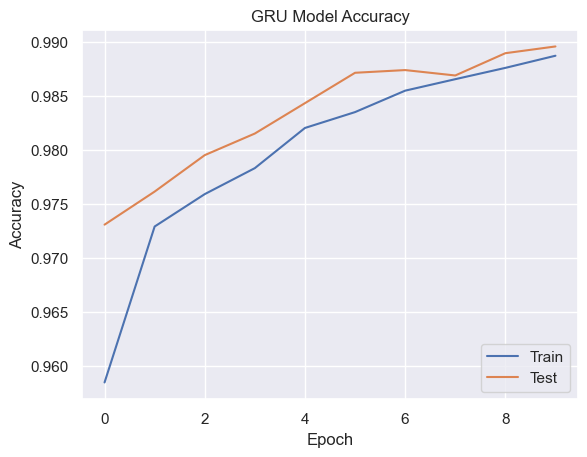

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(model_name+' Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('./'+model_name+'/'+model_name+' Model Accuracy.png')
plt.show()

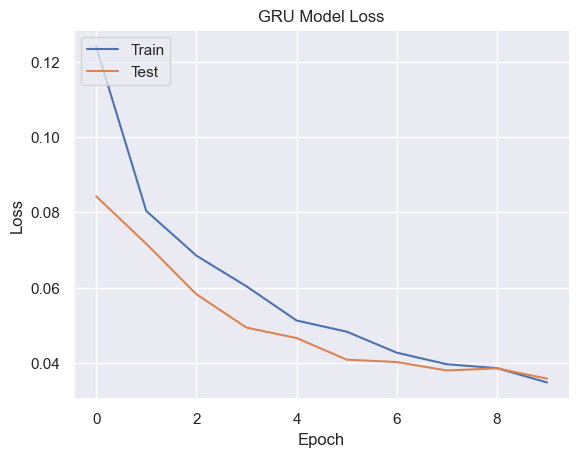

In [25]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(model_name+' Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./'+model_name+'/'+model_name+' Model Loss.png')
plt.show()


In [26]:
predict = model.predict(X_test, verbose=1)

625/625 [==============================] - 2s 3ms/step


In [27]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1


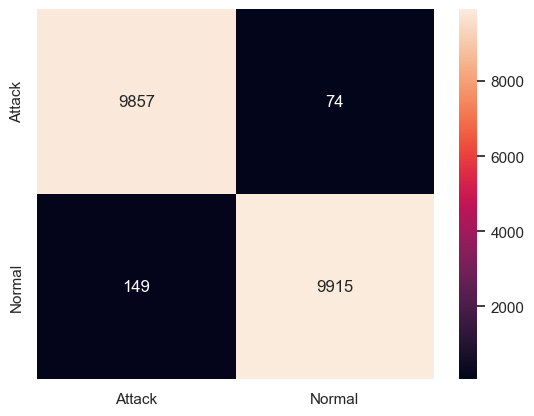

In [28]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [29]:
figure = ax.get_figure()    
figure.savefig('./'+model_name+'/'+model_name+'_confusion_matrix.png', dpi=400)

In [30]:
model.save('./'+model_name+'/'+model_name+'_model.keras')

In [31]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 98.88%


In [ ]:
live_data = pd.read_csv('packets.csv')
live_data = live_data[features]
